### Credit Scoring with Xgboost

Take the cleaned data and selected features from step 1 & step2 for modelling

**Pros of Xgboost:**
- XGBoost support parallel processing in tree splitting
- XGBoost provides regularization options to avoid overfitting.
- Traditional GBDT use decision tree as classifier, while XGBoost support multiple classifiers.
- GBDT use first derivatives to minimise loss function while XGBoost apply second-order Taylor expansion on the loss function, which is faster and more accurate.
- GBDT use all training sample in every iteration while XGBoost support random sampling like random forest
- XGBoost has a built-in routine to handle missing values
- XGBoost has Built-in Cross-Validation
- GBDT is a greedy algorithm as it stops when it encounters a negative loss in the split while XGBoost splits upto the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain.

**Cons of Xgboost:**
- Time consuming for hyper-parameter tuning

**Aim**
- In this notebook, I will apply the xgboost model to predict the default, and tune the hyper parameter with cross-validattiion based on package **scikit-learn**

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use('fivethirtyeight')

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', 1000, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mp.style.use('ggplot')
sns.set(style='whitegrid')

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA 
from sklearn.feature_selection import f_classif
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import ElasticNet, Ridge, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_json('input/CleanedData.json', orient='table')
df = df[[c for c in df if c not in ['loan_status']] + ['loan_status']]

In [3]:
df.head(2)

,loan_amnt,term,emp_length,home_ownership,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,mths_since_last_major_derog,acc_now_delinq,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,avg_cur_bal,bc_open_to_buy,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_sats,num_bc_tl,num_il_tl,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,tax_liens,tot_hi_cred_lim,earliest_cr_line_length,is_manager,is_teacher,title_car financing,title_credit card refinancing,title_debt consolidation,title_green loan,title_home buying,title_home improvement,title_major purchase,title_medical expenses,title_moving and relocation,title_other,title_vacation,application_type_joint app,disbursement_method_directpay,emp_length_present,mths_since_last_delinq_present,mths_since_last_record_present,revol_util_present,mths_since_last_major_derog_present,mths_since_rcnt_il_present,il_util_present,all_util_present,avg_cur_bal_present,bc_open_to_buy_present,mo_sin_old_il_acct_present,mths_since_recent_bc_present,mths_since_recent_bc_dlq_present,mths_since_recent_inq_present,pct_tl_nvr_dlq_present,loan_status
421101,3000.0,36.0,9.0,5,52000.0,0.58,0.0,760.0,0.0,26.0,NaN,7.0,0.0,141.0,0.5,30.0,NaN,0.0,0.0,0.0,1.0,2.0,7.0,0.0,NaN,0.0,1.0,141.0,1.0,31000.0,1.0,2.0,2.0,25099.0,30359.0,0.0,0.0,132.0,242.0,18.0,7.0,4.0,18.0,NaN,7.0,0.0,1.0,4.0,15.0,7.0,0.0,96.7,0.0,191216.0,7364,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,1,1,1,1,0,1,1,0
421113,5000.0,36.0,10.0,4,55000.0,14.18,0.0,675.0,0.0,74.0,82.0,14.0,1.0,11449.0,33.9,24.0,74.0,0.0,1.0,1.0,0.0,0.0,33.0,17431.0,63.0,2.0,2.0,4829.0,47.0,33800.0,0.0,1.0,1.0,2222.0,10551.0,0.0,0.0,77.0,199.0,3.0,3.0,0.0,3.0,NaN,12.0,1.0,3.0,4.0,7.0,6.0,0.0,95.7,0.0,61551.0,6056,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0


In [4]:
df.isna().mean().sort_values().tail(10)

bc_open_to_buy                 0.016977
mo_sin_old_il_acct             0.033173
mths_since_rcnt_il             0.033173
mths_since_recent_inq          0.083483
emp_length                     0.087621
il_util                        0.166309
mths_since_last_delinq         0.552485
mths_since_last_major_derog    0.758022
mths_since_recent_bc_dlq       0.793912
mths_since_last_record         0.852178
dtype: float64

#### 1. Train Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], 
                                                    df.iloc[:,-1], 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                   stratify=df.iloc[:,-1])

In [6]:
y_train.mean(), y_test.mean()

(0.15745980631259915, 0.15747975564710898)

In [7]:
X_train.shape, X_test.shape

((42233, 85), (14078, 85))

#### 2. Short list
From script 1 - festure selection

In [10]:
short_cols = ['tot_hi_cred_lim', 'mort_acc', 'avg_cur_bal', 'fico_range_low',
       'loan_amnt', 'bc_open_to_buy', 'term', 'home_ownership',
       'total_acc', 'num_il_tl', 'total_rev_hi_lim', 'revol_util',
       'mo_sin_old_il_acct', 'mths_since_recent_inq', 'emp_length',
       'inq_last_6mths', 'dti', 'all_util', 'annual_inc', 'open_il_24m',
       'emp_length_present', 'mo_sin_old_il_acct_present',
       'mths_since_rcnt_il_present', 'mths_since_last_major_derog',
       'max_bal_bc', 'mths_since_rcnt_il', 'revol_bal']

In [25]:
X_train = X_train[short_cols]
X_test = X_test[short_cols]

In [11]:
dtrain = xgb.DMatrix(X_train[short_cols].values, label=y_train.values)
dtest = xgb.DMatrix(X_test[short_cols].values, label=y_test.values)

#### 3. Modelling

In [12]:
params = {
    # Parameters that we are going to tune.
    'n_estimators': 100,
    'eta':.1,
    'max_depth':6,
    'min_child_weight': 1,
    'gamma': 0.1,
    'subsample': 1,
    'colsample_bytree': 1,
    'reg_alpha': 1e-05,
    'reg_lambda': 1,
    # Parameters that we are not going to tune.
    'objective': 'binary:logistic',
    'eval_metric': "auc",
}

##### 3.1 A simple model with initilised parameters

In [13]:
xgb1 = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate =0.1, 
    max_depth=6,
    min_child_weight=1,
    gamma = 0.1, # Minimum loss reduction required to make a further partition on a leaf node of the tree
    subsample=1,
    colsample_bytree=1,
    reg_alpha=1e-05,
    reg_lambda=1,
    objective= 'binary:logistic',
    nthread=4, # Number of parallel threads used to run XGBoost
    seed=27
)

xgb1.fit(X_train[short_cols], y_train);

In [14]:
#Print model report on trainiing sample
dtrain_predictions = xgb1.predict(X_train[short_cols])
dtrain_predprob = xgb1.predict_proba(X_train[short_cols])[:,1]
print ("\nModel Report")
print ("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))

#Print model report on trainiing sample
dtest_predictions = xgb1.predict(X_test[short_cols])
dtest_predprob = xgb1.predict_proba(X_test[short_cols])[:,1]
print ("\nModel Report")
print ("Accuracy : %.4g" % metrics.accuracy_score(y_test.values, dtest_predictions))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, dtest_predprob))


Model Report
Accuracy : 0.8635
AUC Score (Train): 0.851319

Model Report
Accuracy : 0.8422
AUC Score (Train): 0.719572


**Overfitting?** 

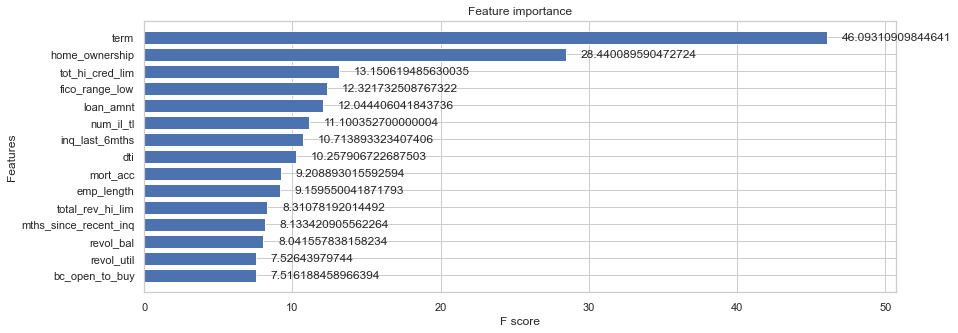

In [15]:
# feature importance
fig, ax = plt.subplots(figsize=(12,5))
xgb.plot_importance(xgb1, max_num_features=15, height=0.8, importance_type='gain', ax=ax)
plt.show()

##### 3.2 Grid Search + Corss validation (Scikit Learn)

**Step 1:** Fix learning rate and number of estimators for tuning tree-based parameters
- initilise the learning rate as 0.1 find the best number of estimators

In [16]:
param_test1 = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

gsearch1 = GridSearchCV(
    estimator = xgb1, 
    param_grid = param_test1, 
    scoring='roc_auc',
    n_jobs=4,
    iid=False, 
    cv=5)

gsearch1.fit(X_train[short_cols], y_train);

gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 100}, 0.7232256792131226)

**Step 2:** Tune max_depth and min_child_weight

In [17]:
param_test2 = {
    'max_depth':range(3,8,2),
    'min_child_weight':range(1,6,2)
}

gsearch2 = GridSearchCV(
     estimator = xgb.XGBClassifier( 
        learning_rate =0.1, 
        n_estimators=100, 
        max_depth=5,
        min_child_weight=1, 
        subsample=1, 
        colsample_bytree=1,
        gamma = 0,
        objective= 'binary:logistic', 
        nthread=4,
        scale_pos_weight=1, 
        seed=27), 
    param_grid = param_test2, 
    scoring='roc_auc',
    n_jobs=4,
    iid=False, 
    cv=5)

gsearch2.fit(X_train[short_cols], y_train);
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 5, 'min_child_weight': 5}, 0.7263158231300311)

**Step 3:** Tune gamma

In [26]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(
    estimator = xgb.XGBClassifier( 
        learning_rate =0.1, 
        n_estimators=100, 
        max_depth=5,
        min_child_weight=5, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1,seed=27), 
    
    param_grid = param_test3, 
    scoring='roc_auc',
    n_jobs=4,
    cv=5)

gsearch3.fit(X_train, y_train);
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.4}, 0.7272110258433775)

**Step 4:** Tune subsample and colsample_bytree

In [27]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]
}
gsearch4 = GridSearchCV(
    estimator = xgb.XGBClassifier( 
        learning_rate =0.1, 
        n_estimators=100, 
        max_depth=5,
        min_child_weight=5, 
        gamma=0.4, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1,
        seed=27), 
    param_grid = param_test4, 
    scoring='roc_auc',
    n_jobs=4,
    cv=5)

gsearch4.fit(X_train, y_train);
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.8}, 0.7281925006172116)

**Step 5:** Tuning Regularization Parameters

In [29]:
param_test5 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch5 = GridSearchCV(
    estimator = xgb.XGBClassifier( 
        learning_rate =0.1, 
        n_estimators=100, 
        max_depth=5,
        min_child_weight=5, 
        gamma=0.4, 
        subsample=0.9, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1,
        seed=27), 
    param_grid = param_test5, 
    scoring='roc_auc',
    n_jobs=4,
    iid=False, 
    cv=5)

gsearch5.fit(X_train, y_train);
gsearch5.best_params_, gsearch4.best_score_

({'reg_alpha': 0.1}, 0.7281925006172116)

**Step 6:** Reducing Learning Rate

In [30]:
xgb2 = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.1,
 objective= 'binary:logistic',
 verbosity = 0,
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb2.fit(X_train, y_train);

In [32]:
#Print model report on trainiing sample
dtrain_predictions = xgb2.predict(X_train)
dtrain_predprob = xgb2.predict_proba(X_train)[:,1]
print ("\nModel Report")
print ("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))

#Print model report on trainiing sample
dtest_predictions = xgb2.predict(X_test)
dtest_predprob = xgb2.predict_proba(X_test)[:,1]
print ("\nModel Report")
print ("Accuracy : %.4g" % metrics.accuracy_score(y_test.values, dtest_predictions))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, dtest_predprob))


Model Report
Accuracy : 0.8467
AUC Score (Train): 0.754526

Model Report
Accuracy : 0.8438
AUC Score (Train): 0.726183


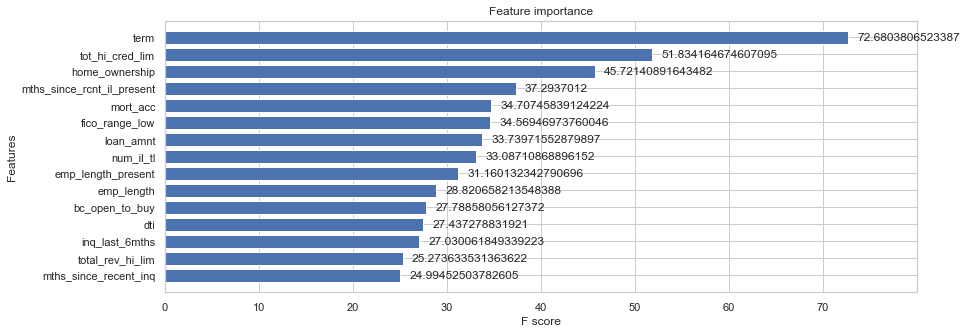

In [33]:
# feature importance
fig, ax = plt.subplots(figsize=(12,5))
xgb.plot_importance(xgb2, max_num_features=15, height=0.8, ax=ax, importance_type='gain')
plt.show()

In [34]:
# 1) kfold cross validation by scikit learn
kfold = KFold(n_splits=5, random_state=3)
results = cross_val_score(xgb2, X_train, y_train, cv=kfold, scoring="roc_auc")
print("AUC: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

AUC: 72.74% (0.65%)


In [36]:
# 2) kfold cross validation by xgboost
cv_results = xgb.cv(
    params = xgb2.get_xgb_params(),
    dtrain = dtrain,
    num_boost_round=1000,
    seed=42,
    nfold=5,
    metrics={'auc'},
    early_stopping_rounds=10
)
cv_results.tail(5)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
995,0.759097,0.001808,0.727707,0.009722
996,0.759122,0.001804,0.727712,0.009704
997,0.759140,0.001806,0.727723,0.009708
998,0.759164,0.001806,0.727728,0.009718
999,0.759183,0.001810,0.727741,0.009707
